In [12]:
import xarray as xr
from matplotlib import pyplot as plt
import xgcm

In [53]:
file = '/projects/DEIKE/jiarongw/multilayer/JPO/processed/temp_new_new/field80.nc'
ds = xr.open_dataset(file)

In [54]:
ds

<xarray.Dataset> Size: 692MB
Dimensions:  (t: 1, zl: 15, x: 1024, y: 1024, x_g: 1024, y_g: 1024, zl_g: 15)
Coordinates:
  * x        (x) float64 8kB -99.9 -99.71 -99.51 -99.32 ... 99.51 99.71 99.9
  * x_g      (x_g) float64 8kB -100.0 -99.8 -99.61 -99.41 ... 99.41 99.61 99.8
  * y        (y) float64 8kB -99.9 -99.71 -99.51 -99.32 ... 99.51 99.71 99.9
  * y_g      (y_g) float64 8kB -100.0 -99.8 -99.61 -99.41 ... 99.41 99.61 99.8
  * zl       (zl) int64 120B 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
  * zl_g     (zl_g) float64 120B -0.5 0.5 1.5 2.5 3.5 ... 10.5 11.5 12.5 13.5
    z        (t, zl, x, y) float64 126MB ...
    z_g      (t, zl_g, x, y) float64 126MB ...
Dimensions without coordinates: t
Data variables:
    h        (t, zl, x, y) float32 63MB ...
    ux       (t, zl, x, y) float32 63MB ...
    uy       (t, zl, x, y) float32 63MB ...
    uz       (t, zl, x, y) float32 63MB ...
    omegax   (t, zl, x, y) float32 63MB ...
    omegay   (t, zl, x, y) float32 63MB ...
    omegaz   (t, zl, x, y) float32 63MB ...
Attributes:
    sourcepath:  /projects/DEIKE/jiarongw/multilayer/revision/field_new_200m_...
    L:           200
    P:           0.02
    Re:          40000
    LEVEL:       10
    NL:          15
    rand:        2
    Htheta:      0.503
    H:           40.0
    label:       temp_new_new

In [45]:
grid = xgcm.Grid(ds, 
                 coords={
                     'X':{'center':'x', 'left':'x_g'},
                     'Y':{'center':'y', 'left':'y_g'},
                     'Z':{'center':'zl', 'left':'zl_g'},
                 },
                 periodic={'X':'True','Y':'True','Z':'False'},
                 boundary={'Z':'fill'},
                 fill_value={'Z':0})
grid

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   x --> left
  * left     x_g --> center
Y Axis (periodic, boundary=None):
  * center   y --> left
  * left     y_g --> center
Z Axis (periodic, boundary='fill'):
  * center   zl --> left
  * left     zl_g --> center

In [46]:
def dissipation_layer(ds, grid):
    
    delta = ds.x[1]-ds.x[0]
    
    dudx = grid.interp(grid.diff(ds.ux, 'X'), 'X')/delta
    dudy = grid.interp(grid.diff(ds.ux, 'Y'), 'Y')/delta
    dudzl = grid.interp(grid.diff(ds.ux, 'Z'), 'Z')
    dvdx = grid.interp(grid.diff(ds.uy, 'X'), 'X')/delta
    dvdy = grid.interp(grid.diff(ds.uy, 'Y'), 'Y')/delta
    dvdzl = grid.interp(grid.diff(ds.uy, 'Z'), 'Z')
    dwdx = grid.interp(grid.diff(ds.uz, 'X'), 'X')/delta
    dwdy = grid.interp(grid.diff(ds.uz, 'Y'), 'Y')/delta
    dwdzl = grid.interp(grid.diff(ds.uz, 'Z'), 'Z')
    
    dzdx = grid.interp(grid.diff(ds.z, 'X'), 'X')/delta
    dzdy = grid.interp(grid.diff(ds.z, 'Y'), 'Y')/delta
    dzdzl = grid.interp(grid.diff(ds.z, 'Z'), 'Z')
    
    ds['dudz'] = dudzl/dzdzl
    ds['dudy'] = dudy - ds['dudz']*dzdy
    ds['dudx'] = dudx - ds['dudz']*dzdx
    ds['dvdz'] = dvdzl/dzdzl
    ds['dvdy'] = dvdy - ds['dvdz']*dzdy
    ds['dvdx'] = dvdx - ds['dvdz']*dzdx
    ds['dwdz'] = dwdzl/dzdzl
    ds['dwdy'] = dwdy - ds['dwdz']*dzdy
    ds['dwdx'] = dwdx - ds['dwdz']*dzdx
    
    ds['epsilon'] = 2*(ds.dudx**2+ds.dvdy**2+ds.dwdz**2) + 
                    4*((0.5*(ds.dudy + ds.dvdx))**2 + (0.5*(ds.dudz+ds.dwdx))**2 + (0.5*(ds.dvdz+ds.dwdy))**2)
    
    ds['omegaxp'] = ds.dwdy - ds.dvdz
    ds['omegayp'] = ds.dudz - ds.dwdx
    ds['omegazp'] = ds.dvdx - ds.dudy
    ds['vort2'] = ds.omegaxp**2 + ds.omegayp**2 + ds.omegazp**2
    
    return ds

In [69]:
def surface_norm (ds):
    delta = ds.x[1]-ds.x[0]
    ds['eta'] = ds.h.sum(dim='zl') - ds.attrs['H']
    detadx = grid.interp(grid.diff(ds.eta, 'X'), 'X')/delta
    detady = grid.interp(grid.diff(ds.eta, 'Y'), 'Y')/delta
    norm = (detadx**2 + detady**2 + (detadx/detadx)**2)**0.5
    ds['normx'] = detadx/norm
    ds['normy'] = detady/norm
    ds['normz'] = -detadx/detadx/norm
    return ds

In [55]:
ds = dissipation_layer(ds, grid)

/scratch/gpfs/jiarongw/CONDA/envs/gp/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [70]:
ds = surface_norm (ds)

/scratch/gpfs/jiarongw/CONDA/envs/gp/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


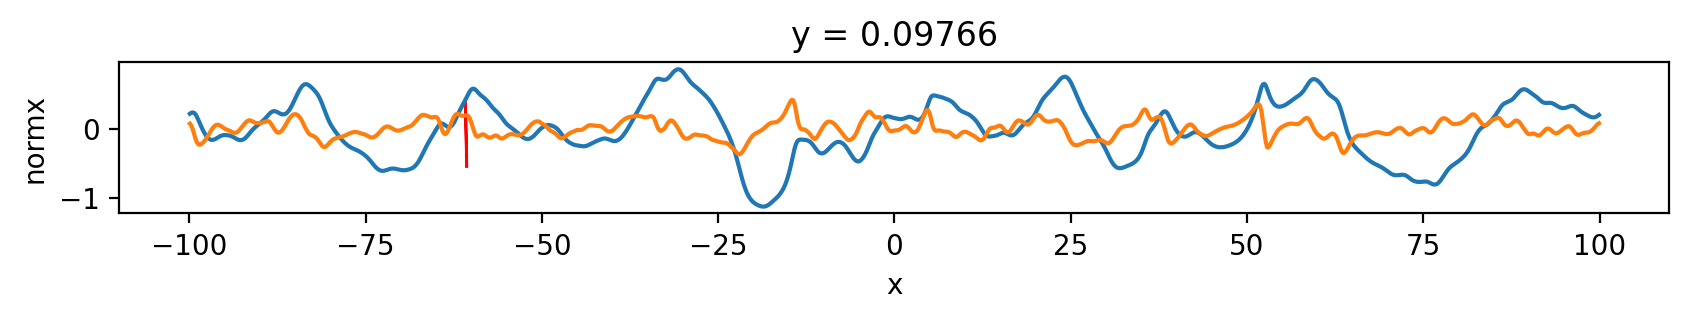

In [81]:
fig = plt.figure(figsize=[10,1], dpi=200); ax = plt.gca()

nx = 200
ds.eta.isel(t=0,y=512).plot(x='x')
ds.normx.isel(t=0,y=512).plot(x='x')
x = ds.x.isel(x=nx)
eta = ds.eta.isel(t=0,y=512,x=nx)

arrow = plt.Arrow(x, eta, ds.normx.isel(t=0,y=512,x=nx), ds.normz.isel(t=0,y=512,x=nx), color='red', width=0.1)
ax.add_patch(arrow)


In [80]:
ds.normx.isel(t=0,y=512,x=nx)

<xarray.DataArray 'normx' ()> Size: 8B
array(0.19487172)
Coordinates:
    x        float64 8B -60.84
    y        float64 8B 0.09766

(-5.0, 1.0)

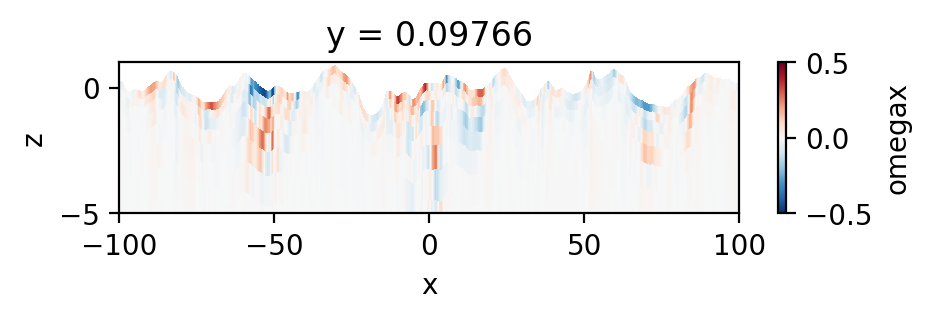

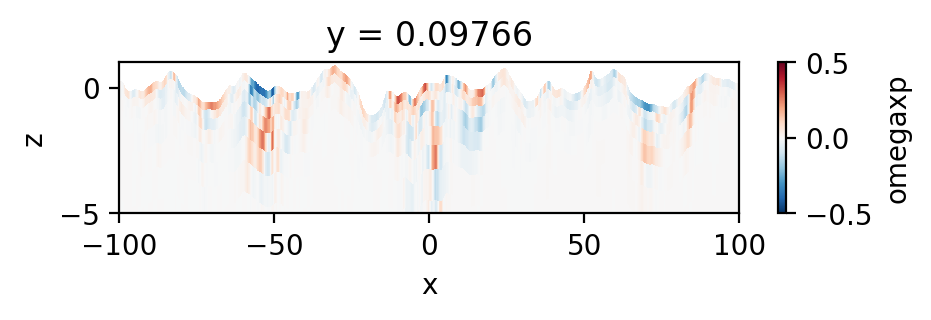

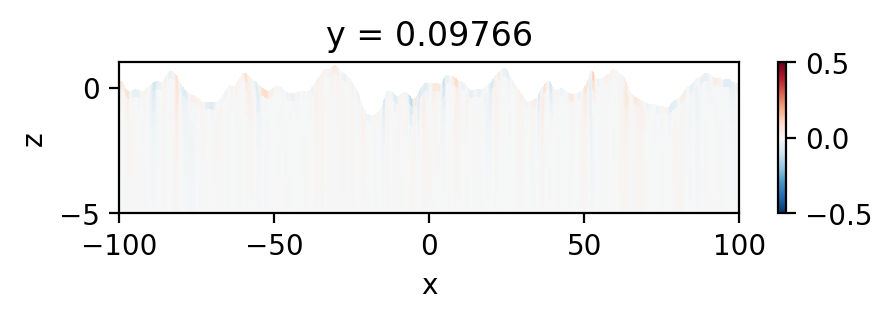

In [56]:
fig = plt.figure(figsize=[5,1],dpi=200)
ds.omegax.isel(t=0,y=512).plot(x='x', y='z', vmax=0.5, vmin=-0.5, cmap='RdBu_r')
plt.ylim([-5,1])

fig = plt.figure(figsize=[5,1],dpi=200)
ds.omegaxp.isel(t=0,y=512).plot(x='x', y='z', vmax=0.5, vmin=-0.5, cmap='RdBu_r')
plt.ylim([-5,1])

fig = plt.figure(figsize=[5,1],dpi=200)
diff = ds.omegaxp - ds.omegax
diff.isel(t=0,y=512).plot(x='x', y='z', vmax=0.5, vmin=-0.5, cmap='RdBu_r')
plt.ylim([-5,1])

(-5.0, 1.0)

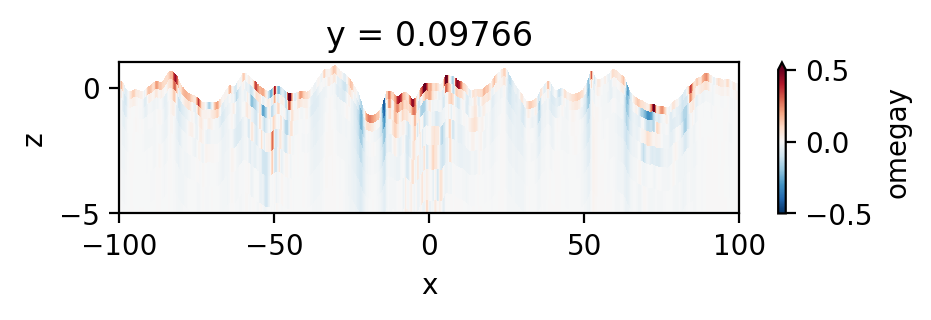

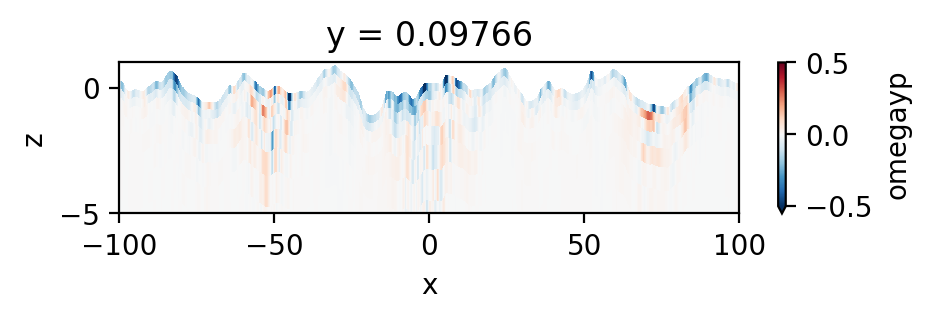

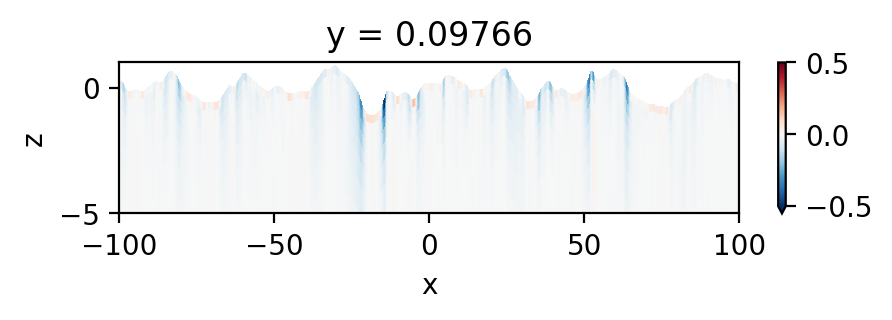

In [57]:
fig = plt.figure(figsize=[5,1],dpi=200)
ds.omegay.isel(t=0,y=512).plot(x='x', y='z', vmax=0.5, vmin=-0.5, cmap='RdBu_r')
plt.ylim([-5,1])

fig = plt.figure(figsize=[5,1],dpi=200)
ds.omegayp.isel(t=0,y=512).plot(x='x', y='z', vmax=0.5, vmin=-0.5, cmap='RdBu_r')
plt.ylim([-5,1])

fig = plt.figure(figsize=[5,1],dpi=200)
diff = ds.omegayp + ds.omegay
diff.isel(t=0,y=512).plot(x='x', y='z', vmax=0.5, vmin=-0.5, cmap='RdBu_r')
plt.ylim([-5,1])

(-5.0, 1.0)

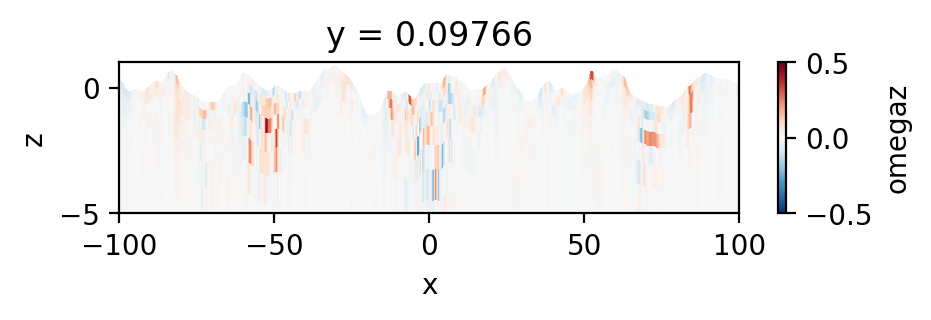

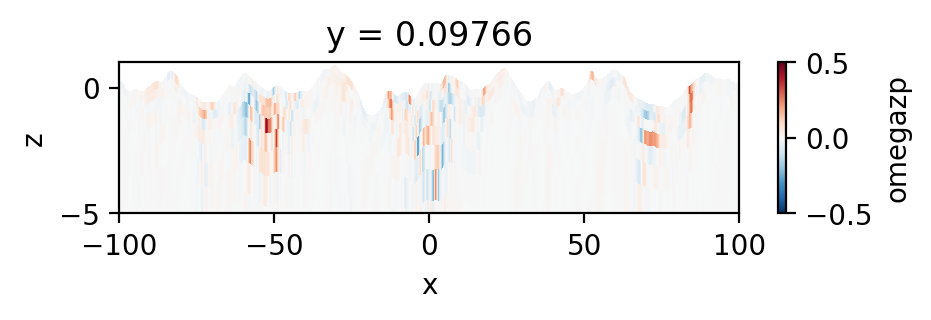

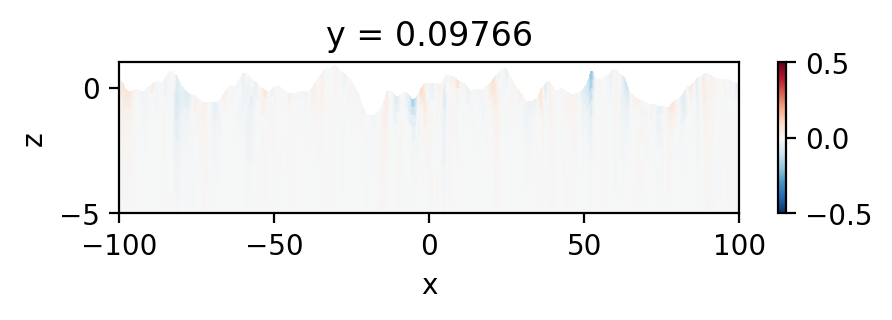

In [50]:
fig = plt.figure(figsize=[5,1],dpi=200)
ds.omegaz.isel(t=0,y=512).plot(x='x', y='z', vmax=0.5, vmin=-0.5, cmap='RdBu_r')
plt.ylim([-5,1])

fig = plt.figure(figsize=[5,1],dpi=200)
ds.omegazp.isel(t=0,y=512).plot(x='x', y='z', vmax=0.5, vmin=-0.5, cmap='RdBu_r')
plt.ylim([-5,1])

fig = plt.figure(figsize=[5,1],dpi=200)
diff = ds.omegazp - ds.omegaz
diff.isel(t=0,y=512).plot(x='x', y='z', vmax=0.5, vmin=-0.5, cmap='RdBu_r')
plt.ylim([-5,1])

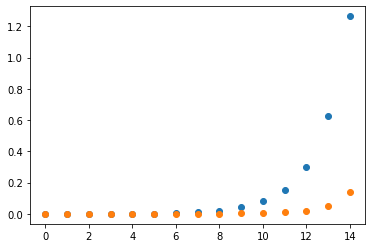

In [60]:
plt.plot(ds.epsilon.isel(t=0).mean(dim=['x','y']), 'o')
plt.plot(ds.vort2.isel(t=0).mean(dim=['x','y']), 'o')

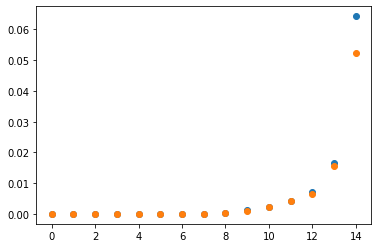

In [58]:
q1 = ds.omegax.isel(t=0)**2
plt.plot(q1.mean(dim=['x','y']), 'o')
q2 = ds.omegaxp.isel(t=0)**2
plt.plot(q2.mean(dim=['x','y']), 'o')
q3 = ds.epsilon.isel(t=0)

In [ ]:
plt.plot(ds.omegaz.isel(t=0).mean(dim=['x','y']), 'o')
plt.plot(ds.omegazp.isel(t=0).mean(dim=['x','y']), 'o')